In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from selenium import webdriver
import main
import visuals
import seaborn as sns
import chromedriver_autoinstaller
from datetime import datetime

In [2]:
chromedriver_autoinstaller.install()

'/Users/joewilliamson/opt/anaconda3/envs/dataAnalysis/lib/python3.9/site-packages/chromedriver_autoinstaller/109/chromedriver'

## To Change
- Link to match report of game from whoscored
- Depends on whether you want home/away team. Pretty simple either way.
- Currently for home team - if you want the home team, change nothing.
- For the Away team change (1) id1 to id2 in the Keep T1 Players section and (2) change home <--> away teams in title and (3) change home > away in section Get Shirt Numbers and merge to passes df

## Pull Data

In [3]:
if __name__ == "__main__":
    driver = webdriver.Chrome()
    
# whoscored match centre url of the required match (Example: Barcelona vs Sevilla)
url = "https://www.whoscored.com/Matches/1640867/Live/England-Premier-League-2022-2023-Chelsea-Crystal-Palace"
match_data = main.getMatchData(driver, url, close_window=True)

# Match dataframe containing info about the match
matches_df = main.createMatchesDF(match_data)

# Events dataframe      
events_df = main.createEventsDF(match_data)

# match Id
matchId = match_data['matchId']

# Information about respective teams as dictionary
home_data = matches_df['home'][matchId]
away_data = matches_df['away'][matchId]

home_name = home_data['name']
away_name = away_data['name']
date = match_data['startDate'].split('T')[0]
date_ = datetime.strptime(date, '%Y-%m-%d').date()
date_str = date_.strftime('%b %d %Y')

Region: England, League: Premier League, Season: 2022/2023, Match Id: 1640867


/Users/joewilliamson/Python/Football Analytics/Whoscored Data/main.py:471: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  events_df[event_type] = pd.Series([event_type in row for row in list(events_df['satisfiedEventsTypes'])])


## Filter data to get passes
- Whoscored doesn't have pass recipient - so need to add automatically
- Just shift index by one
- Also have instances where pass is successful but recipient is to another team (half end/free kicks?) - so make sure team id or recipient and player is the same

In [4]:
events_df["passRecipient"] = events_df['playerName'].shift(-1)
events_df['teamRecipient'] = events_df['teamId'].shift(-1)
column_to_move = events_df.pop("passRecipient")
events_df.insert(26, "passRecipient", column_to_move)
column_to_move = events_df.pop("teamRecipient")
events_df.insert(27, "teamRecipient", column_to_move)

/var/folders/64/5g4jhyss7mg53kswrwkk3v_c0000gn/T/ipykernel_8179/217841738.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  events_df["passRecipient"] = events_df['playerName'].shift(-1)
/var/folders/64/5g4jhyss7mg53kswrwkk3v_c0000gn/T/ipykernel_8179/217841738.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  events_df['teamRecipient'] = events_df['teamId'].shift(-1)
/Users/joewilliamson/opt/anaconda3/envs/dataAnalysis/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3364: PerformanceWarning: DataFrame is highl

In [5]:
events_df2 = events_df[(events_df['type'] == 'Pass')]

In [6]:
events_df = events_df[(events_df['type'] == 'Pass') & (events_df['outcomeType'] == 'Successful')
                      & (events_df['teamId'] == events_df['teamRecipient']) ]

## Passes between 2 players

In [7]:
passes_df = events_df[['eventId','playerName', 'passRecipient']]
passes_df = passes_df.dropna()

In [8]:
passes_df['pair'] = passes_df['playerName'] + ' ' + passes_df['passRecipient']
passes_df

,eventId,playerName,passRecipient,pair
2,3,Michael Olise,Marc Guéhi,Michael Olise Marc Guéhi
3,4,Marc Guéhi,Jordan Ayew,Marc Guéhi Jordan Ayew
8,5,Kepa Arrizabalaga,Thiago Silva,Kepa Arrizabalaga Thiago Silva
9,6,Thiago Silva,Hakim Ziyech,Thiago Silva Hakim Ziyech
10,7,Hakim Ziyech,Trevoh Chalobah,Hakim Ziyech Trevoh Chalobah
...,...,...,...,...
1708,797,Vicente Guaita,James Tomkins,Vicente Guaita James Tomkins
1716,801,Wilfried Zaha,Tyrick Mitchell,Wilfried Zaha Tyrick Mitchell
1718,803,Tyrick Mitchell,Wilfried Zaha,Tyrick Mitchell Wilfried Zaha
1719,804,Wilfried Zaha,Marc Guéhi,Wilfried Zaha Marc Guéhi


In [9]:
passes_count = passes_df.groupby(['pair']).count().reset_index()
passes_count = passes_count[['pair', 'eventId']]
passes_count.columns = ['pair', 'passes']
passes_count

,pair,passes
0,Benoît Badiashile Carney Chukwuemeka,3
1,Benoît Badiashile Conor Gallagher,7
2,Benoît Badiashile Hakim Ziyech,3
3,Benoît Badiashile Jorginho,15
4,Benoît Badiashile Kai Havertz,2
...,...,...
211,Will Hughes Michael Olise,2
212,Will Hughes Nathaniel Clyne,1
213,Will Hughes Odsonne Édouard,1
214,Will Hughes Tyrick Mitchell,1


## Average position for each player

In [10]:
avg_loc_df = events_df[['teamId', 'playerName', 'x', 'y']]
avg_loc_df = avg_loc_df.groupby(['teamId', 'playerName']).agg({'x':np.mean, 'y':[np.mean, 'count']}).reset_index()
avg_loc_df.columns = ['teamId', 'playerName', 'x','y', 'count']
avg_loc_df

,teamId,playerName,x,y,count
0,15,Benoît Badiashile,37.235211,66.438028,71
1,15,Carney Chukwuemeka,60.206250,76.787500,16
2,15,Conor Gallagher,55.572881,39.079661,59
3,15,Hakim Ziyech,70.494286,19.862857,35
4,15,Jorginho,47.801563,49.607813,64
5,15,Kai Havertz,62.327778,42.150000,18
6,15,Kalidou Koulibaly,35.766667,90.333333,3
7,15,Kepa Arrizabalaga,10.922222,49.996296,27
8,15,Lewis Hall,56.165306,89.432653,49
9,15,Mason Mount,65.622857,55.471429,35


## Merge Data  

In [11]:
passes_merge = passes_df.merge(passes_count, on='pair')
passes_merge = passes_merge[['playerName', 'passRecipient', 'passes']]
passes_merge = passes_merge.drop_duplicates().reset_index(drop=True)
passes_merge

,playerName,passRecipient,passes
0,Michael Olise,Marc Guéhi,2
1,Marc Guéhi,Jordan Ayew,4
2,Kepa Arrizabalaga,Thiago Silva,15
3,Thiago Silva,Hakim Ziyech,4
4,Hakim Ziyech,Trevoh Chalobah,6
...,...,...,...
211,Michael Olise,Will Hughes,1
212,Michael Olise,Vicente Guaita,1
213,Wilfried Zaha,Tyrick Mitchell,1
214,Wilfried Zaha,Marc Guéhi,1


In [12]:
avg_loc_df = avg_loc_df[['playerName', 'x', 'y', 'count']]
pass_map = passes_merge.merge(avg_loc_df, on='playerName')
pass_map.rename({'x':'x_start', 'y':'y_start'}, axis='columns', inplace=True)
pass_map = pass_map.merge(avg_loc_df, left_on = 'passRecipient', right_on='playerName', suffixes = ['', '_end'])
pass_map.rename({'x':'x_end', 'y':'y_end'}, axis='columns', inplace=True)
pass_map = pass_map.drop(['playerName_end', 'count_end'], axis=1)
pass_map = pass_map[pass_map['playerName'] != pass_map['passRecipient']]
pass_map

,playerName,passRecipient,passes,x_start,y_start,count,x_end,y_end
0,Michael Olise,Marc Guéhi,2,65.537209,25.162791,43,43.528125,68.809375
1,Cheick Oumar Doucouré,Marc Guéhi,2,56.161538,38.657692,26,43.528125,68.809375
2,Vicente Guaita,Marc Guéhi,6,12.433333,49.077778,18,43.528125,68.809375
3,Tyrick Mitchell,Marc Guéhi,3,53.900000,88.984615,26,43.528125,68.809375
4,Jeffrey Schlupp,Marc Guéhi,5,51.664286,69.200000,14,43.528125,68.809375
...,...,...,...,...,...,...,...,...
210,Benoît Badiashile,Kalidou Koulibaly,1,37.235211,66.438028,71,35.766667,90.333333
211,Nathaniel Clyne,Jean-Philippe Mateta,1,59.111111,10.333333,36,48.766667,29.933333
212,James Tomkins,Jean-Philippe Mateta,1,36.761538,38.853846,13,48.766667,29.933333
213,Pierre-Emerick Aubameyang,Mateo Kovacic,1,64.800000,68.225000,4,73.300000,82.000000


## Keep T1 Players

In [13]:
id1 = home_data['teamId']
id2 = away_data['teamId']

In [14]:
team1_players = events_df[events_df.teamId == id1].groupby('playerName').agg({'minute': [min, max]}).reset_index()
team1_players = pd.concat([team1_players['playerName'], team1_players['minute']], axis=1)
team1_players['mins_played'] = team1_players['max'] - team1_players['min']
team1_players = team1_players.sort_values('mins_played', ascending=False)
team1_players_names = team1_players.playerName
passes_t1 = pass_map[(pass_map['playerName'].isin(team1_players_names)) & 
                     (pass_map['passRecipient'].isin(team1_players_names))]
team1_players_names_top11 = team1_players.playerName[:11].tolist()
team1_players_names_top11

['Jorginho',
 'Benoît Badiashile',
 'Conor Gallagher',
 'Mason Mount',
 'Kepa Arrizabalaga',
 'Trevoh Chalobah',
 'Thiago Silva',
 'Hakim Ziyech',
 'Lewis Hall',
 'Kai Havertz',
 'Carney Chukwuemeka']

## Top 3 players with most completed passes

In [15]:
comp_passes = passes_t1.groupby('playerName')[['playerName','passes']].sum().reset_index().sort_values(by='passes',
                                                                                        ascending=False)
comp_passes = comp_passes[comp_passes['playerName'].isin(team1_players_names_top11)][:3]
team1_players_names_top11
comp_passes_list = []
for p, passes in zip(comp_passes['playerName'], comp_passes['passes']):
    comp_passes_list.append([p, passes])
comp_passes_list

[['Benoît Badiashile', 71], ['Thiago Silva', 70], ['Jorginho', 64]]

## Top 3 Combinations

In [16]:
combos = passes_t1.sort_values(by='passes', ascending=False)
combos = combos[(combos['playerName'].isin(team1_players_names_top11)) & (combos['passRecipient'].isin(team1_players_names_top11))]
combos = combos[:3][['playerName', 'passRecipient', 'passes']]
combos_list = []
for p1, p2, cnt in zip(combos['playerName'], combos['passRecipient'], combos['passes']):
    combos_list.append([p1,p2, cnt])
combos_list

[['Benoît Badiashile', 'Lewis Hall', 20],
 ['Thiago Silva', 'Benoît Badiashile', 19],
 ['Kepa Arrizabalaga', 'Thiago Silva', 15]]

## Prog. Pass Field + Top 3 Prog. Passes

In [17]:
prog_passes = events_df[['playerName', 'passRecipient', 'type', 'x', 'y', 'endX', 'endY']]
prog_passes.rename({'x':'x_start', 'y':'y_start', 'endX': 'x_end', 'endY':'y_end'}, axis='columns', inplace=True)
prog_passes = prog_passes[(prog_passes['playerName'].isin(team1_players_names))]
prog_passes = prog_passes.reset_index(drop=True)

prog_passes['Progressive'] = ''
for i in range(len(prog_passes)):
    x_0 = 120*(prog_passes['x_start'][i])/100
    y_0 = 80*(prog_passes['y_start'][i])/100
    x_1 = 120*(prog_passes['x_end'][i])/100
    y_1 = 80*(prog_passes['y_end'][i])/100
    
    beg_dist = np.sqrt((120 - x_0)**2 + (40 - y_0)**2)
    end_dist = np.sqrt((120 - x_1)**2 + (40 - y_1)**2)

    if end_dist/beg_dist <= 0.75:
        prog_passes['Progressive'][i] = 'True'
    else:
        prog_passes['Progressive'][i] = 'False'

        
prog_passes2 = prog_passes[prog_passes['Progressive'] == 'True'].groupby('playerName')['type'].count().sort_values(ascending=False).reset_index()
prog_passes2 = prog_passes2[prog_passes2['playerName'].isin(team1_players_names_top11)][:3]
prog_passes_list = []
for p, cnt in zip(prog_passes2['playerName'], prog_passes2['type']):
    prog_passes_list.append([p,cnt])

prog_received = pd.DataFrame(prog_passes[prog_passes['Progressive'] == 'True'].groupby('passRecipient')['type'].count().sort_values(ascending=False)).reset_index()
prog_received = prog_received[prog_received['passRecipient'].isin(team1_players_names_top11)][:3]
prog_received_list = []
for p, cnt in zip(prog_received['passRecipient'], prog_received['type']):
    prog_received_list.append([p,cnt])


## Top 3 Pass Completion

In [18]:
events_df2 = events_df2[events_df2['playerName'].isin(team1_players_names_top11)][['playerName','outcomeType']]
pass_comp_df = pd.DataFrame(events_df2.groupby(['playerName', 'outcomeType']).size()).unstack(fill_value=0).stack().reset_index()
pass_comp_df.columns = ['playerName', 'outcome', 'count']
pass_comp = []
for i in range(0, len(pass_comp_df), 2):
    rate = pass_comp_df['count'][i] / (pass_comp_df['count'][i]+pass_comp_df['count'][i+1])
    pass_comp.append([pass_comp_df['playerName'][i], rate])

pass_comp.sort(key=lambda x:x[1], reverse=True)
pass_comp = pass_comp[0:3]
for i, val in enumerate(pass_comp):
    val[1] = round(float(val[1])*100)
pass_comp
    
    

[['Benoît Badiashile', 96], ['Jorginho', 91], ['Thiago Silva', 91]]

## Top 3 xThreat via Pass

In [19]:
events_df_xT = events_df[['playerName', 'x', 'y', 'endX', 'endY']].reset_index(drop=True)

xT_list = []
xT = pd.read_csv("xT_grid.csv", header=None)
xT = np.array(xT)
xT_rows, xT_cols = xT.shape

for name in team1_players_names_top11:
    test = events_df_xT[events_df_xT['playerName'] == name]
    test['x1_bin'] = pd.cut(test['x'], bins=xT_cols, labels=False)
    test['x2_bin'] = pd.cut(test['endX'], bins=xT_cols, labels=False)
    test['y1_bin'] = pd.cut(test['y'], bins=xT_rows, labels=False)
    test['y2_bin'] = pd.cut(test['endY'], bins=xT_rows, labels=False)
    test['xT_start'] = test[['x1_bin', 'y1_bin']].apply(lambda x:xT[x[1]][x[0]], axis=1)
    test['xT_end'] = test[['x2_bin', 'y2_bin']].apply(lambda x:xT[x[1]][x[0]], axis=1)
    test['xT_diff'] = test['xT_end'] - test['xT_start']
    xT_added = test['xT_diff'].sum()
    
    xT_list.append([name, xT_added])
    
xT_list.sort(key=lambda x:x[1], reverse=True)
xT_list2 = xT_list.copy()
xT_list = xT_list[:3]
for i, val in enumerate(xT_list):
    val[1] = round(float(val[1]),2)
xT_list2

[['Hakim Ziyech', 0.43],
 ['Conor Gallagher', 0.37],
 ['Mason Mount', 0.36],
 ['Trevoh Chalobah', 0.24391631000000005],
 ['Jorginho', 0.08531266],
 ['Kai Havertz', 0.034033629999999995],
 ['Thiago Silva', 0.021795359999999993],
 ['Carney Chukwuemeka', -0.02825071],
 ['Lewis Hall', -0.10518046000000002],
 ['Kepa Arrizabalaga', -0.30613606],
 ['Benoît Badiashile', -0.7523939]]

In [20]:
events_df_xT = events_df[['playerName', 'x', 'y', 'endX', 'endY']].reset_index(drop=True)

xT_list = []
path = "https://karun.in/blog/data/open_xt_12x8_v1.json"
xT_grid = pd.read_json(path)
xT_grid = np.array(xT_grid)
xT_grid
xT_rows, xT_cols = xT.shape

for name in team1_players_names_top11:
    test = events_df_xT[events_df_xT['playerName'] == name]
    test['x1_bin'] = pd.cut(test['x'], bins=xT_cols, labels=False)
    test['x2_bin'] = pd.cut(test['endX'], bins=xT_cols, labels=False)
    test['y1_bin'] = pd.cut(test['y'], bins=xT_rows, labels=False)
    test['y2_bin'] = pd.cut(test['endY'], bins=xT_rows, labels=False)
    test['xT_start'] = test[['x1_bin', 'y1_bin']].apply(lambda x:xT[x[1]][x[0]], axis=1)
    test['xT_end'] = test[['x2_bin', 'y2_bin']].apply(lambda x:xT[x[1]][x[0]], axis=1)
    test['xT_diff'] = test['xT_end'] - test['xT_start']
    xT_added = test['xT_diff'].sum()
    
    xT_list.append([name, xT_added])
    
xT_list.sort(key=lambda x:x[1], reverse=True)
xT_list2 = xT_list.copy()
xT_list = xT_list[:3]
for i, val in enumerate(xT_list):
    val[1] = round(float(val[1]),2)
xT_list

[['Hakim Ziyech', 0.43], ['Conor Gallagher', 0.37], ['Mason Mount', 0.36]]

In [21]:
xT_scaled = []
minXT = abs(min(xT_list2, key=lambda x:x[1])[1])
for player, xT in xT_list2:
    xT_updated = xT + minXT + 0.05
    xT_scaled.append([player, xT_updated])
df_xT = pd.DataFrame(xT_scaled, columns=['playerName', 'xThreat'])
df_xT

,playerName,xThreat
0,Hakim Ziyech,1.232394
1,Conor Gallagher,1.172394
2,Mason Mount,1.162394
3,Trevoh Chalobah,1.046310
4,Jorginho,0.887707
5,Kai Havertz,0.836428
6,Thiago Silva,0.824189
7,Carney Chukwuemeka,0.774143
8,Lewis Hall,0.697213
9,Kepa Arrizabalaga,0.496258


## Keep 11 players with most mins

In [22]:
# Get line width and just count instances of 4/more passes
team1_players_names = team1_players.playerName[:11].tolist()
passes_t1 = pass_map[(pass_map['playerName'].isin(team1_players_names)) & 
                     (pass_map['passRecipient'].isin(team1_players_names))]
passes_t1['width'] = passes_t1['passes']/passes_t1['passes'].max() * 12
passes_t1

,playerName,passRecipient,passes,x_start,y_start,count,x_end,y_end,width
105,Kepa Arrizabalaga,Thiago Silva,15,10.922222,49.996296,27,32.912857,33.772857,9.0
106,Hakim Ziyech,Thiago Silva,4,70.494286,19.862857,35,32.912857,33.772857,2.4
107,Trevoh Chalobah,Thiago Silva,9,46.648148,11.483333,54,32.912857,33.772857,5.4
108,Conor Gallagher,Thiago Silva,11,55.572881,39.079661,59,32.912857,33.772857,6.6
109,Mason Mount,Thiago Silva,2,65.622857,55.471429,35,32.912857,33.772857,1.2
...,...,...,...,...,...,...,...,...,...
203,Mason Mount,Carney Chukwuemeka,1,65.622857,55.471429,35,60.206250,76.787500,0.6
204,Lewis Hall,Carney Chukwuemeka,8,56.165306,89.432653,49,60.206250,76.787500,4.8
205,Benoît Badiashile,Carney Chukwuemeka,3,37.235211,66.438028,71,60.206250,76.787500,1.8
206,Kai Havertz,Carney Chukwuemeka,1,62.327778,42.150000,18,60.206250,76.787500,0.6


In [23]:
# Set marker size and keep over 4 passes
# passes_t1 = passes_t1[passes_t1['passes']>=2]
passes_t1['passes'][passes_t1['passes']<3] = 0
passes_t1['marker_size'] = (passes_t1['count']
                                         / passes_t1['count'].max() * 2500)
passes_t1

,playerName,passRecipient,passes,x_start,y_start,count,x_end,y_end,width,marker_size
105,Kepa Arrizabalaga,Thiago Silva,15,10.922222,49.996296,27,32.912857,33.772857,9.0,950.704225
106,Hakim Ziyech,Thiago Silva,4,70.494286,19.862857,35,32.912857,33.772857,2.4,1232.394366
107,Trevoh Chalobah,Thiago Silva,9,46.648148,11.483333,54,32.912857,33.772857,5.4,1901.408451
108,Conor Gallagher,Thiago Silva,11,55.572881,39.079661,59,32.912857,33.772857,6.6,2077.464789
109,Mason Mount,Thiago Silva,0,65.622857,55.471429,35,32.912857,33.772857,1.2,1232.394366
...,...,...,...,...,...,...,...,...,...,...
203,Mason Mount,Carney Chukwuemeka,0,65.622857,55.471429,35,60.206250,76.787500,0.6,1232.394366
204,Lewis Hall,Carney Chukwuemeka,8,56.165306,89.432653,49,60.206250,76.787500,4.8,1725.352113
205,Benoît Badiashile,Carney Chukwuemeka,3,37.235211,66.438028,71,60.206250,76.787500,1.8,2500.000000
206,Kai Havertz,Carney Chukwuemeka,0,62.327778,42.150000,18,60.206250,76.787500,0.6,633.802817


In [24]:
passes_t1 = passes_t1.merge(df_xT, on='playerName')
passes_t1

,playerName,passRecipient,passes,x_start,y_start,count,x_end,y_end,width,marker_size,xThreat
0,Kepa Arrizabalaga,Thiago Silva,15,10.922222,49.996296,27,32.912857,33.772857,9.0,950.704225,0.496258
1,Kepa Arrizabalaga,Benoît Badiashile,6,10.922222,49.996296,27,37.235211,66.438028,3.6,950.704225,0.496258
2,Kepa Arrizabalaga,Trevoh Chalobah,3,10.922222,49.996296,27,46.648148,11.483333,1.8,950.704225,0.496258
3,Kepa Arrizabalaga,Conor Gallagher,0,10.922222,49.996296,27,55.572881,39.079661,0.6,950.704225,0.496258
4,Kepa Arrizabalaga,Jorginho,0,10.922222,49.996296,27,47.801563,49.607813,0.6,950.704225,0.496258
...,...,...,...,...,...,...,...,...,...,...,...
86,Kai Havertz,Jorginho,0,62.327778,42.150000,18,47.801563,49.607813,0.6,633.802817,0.836428
87,Kai Havertz,Hakim Ziyech,3,62.327778,42.150000,18,70.494286,19.862857,1.8,633.802817,0.836428
88,Kai Havertz,Lewis Hall,3,62.327778,42.150000,18,56.165306,89.432653,1.8,633.802817,0.836428
89,Kai Havertz,Mason Mount,0,62.327778,42.150000,18,65.622857,55.471429,0.6,633.802817,0.836428


## Get Shirt Numbers and merge to passes df 

In [25]:
shirt_nos = matches_df['home'][matchId]['formations'][0]['jerseyNumbers']
playerIds = matches_df['home'][matchId]['formations'][0]['playerIds']
shirt_nos = pd.DataFrame({'no':shirt_nos, 'playerId':playerIds})
playerIds = events_df[['playerId', 'playerName']]
passes_t1 = passes_t1.merge(playerIds, on='playerName')
shirt_nos['playerId'] = shirt_nos['playerId'].astype(str)
passes_t1 = passes_t1.merge(shirt_nos, on='playerId')
passes_t1 = passes_t1.drop_duplicates().reset_index(drop=True)
passes_t1

,playerName,passRecipient,passes,x_start,y_start,count,x_end,y_end,width,marker_size,xThreat,playerId,no
0,Kepa Arrizabalaga,Thiago Silva,15,10.922222,49.996296,27,32.912857,33.772857,9.0,950.704225,0.496258,113880,1
1,Kepa Arrizabalaga,Benoît Badiashile,6,10.922222,49.996296,27,37.235211,66.438028,3.6,950.704225,0.496258,113880,1
2,Kepa Arrizabalaga,Trevoh Chalobah,3,10.922222,49.996296,27,46.648148,11.483333,1.8,950.704225,0.496258,113880,1
3,Kepa Arrizabalaga,Conor Gallagher,0,10.922222,49.996296,27,55.572881,39.079661,0.6,950.704225,0.496258,113880,1
4,Kepa Arrizabalaga,Jorginho,0,10.922222,49.996296,27,47.801563,49.607813,0.6,950.704225,0.496258,113880,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
86,Kai Havertz,Jorginho,0,62.327778,42.150000,18,47.801563,49.607813,0.6,633.802817,0.836428,326413,29
87,Kai Havertz,Hakim Ziyech,3,62.327778,42.150000,18,70.494286,19.862857,1.8,633.802817,0.836428,326413,29
88,Kai Havertz,Lewis Hall,3,62.327778,42.150000,18,56.165306,89.432653,1.8,633.802817,0.836428,326413,29
89,Kai Havertz,Mason Mount,0,62.327778,42.150000,18,65.622857,55.471429,0.6,633.802817,0.836428,326413,29


## Plot Passing Network

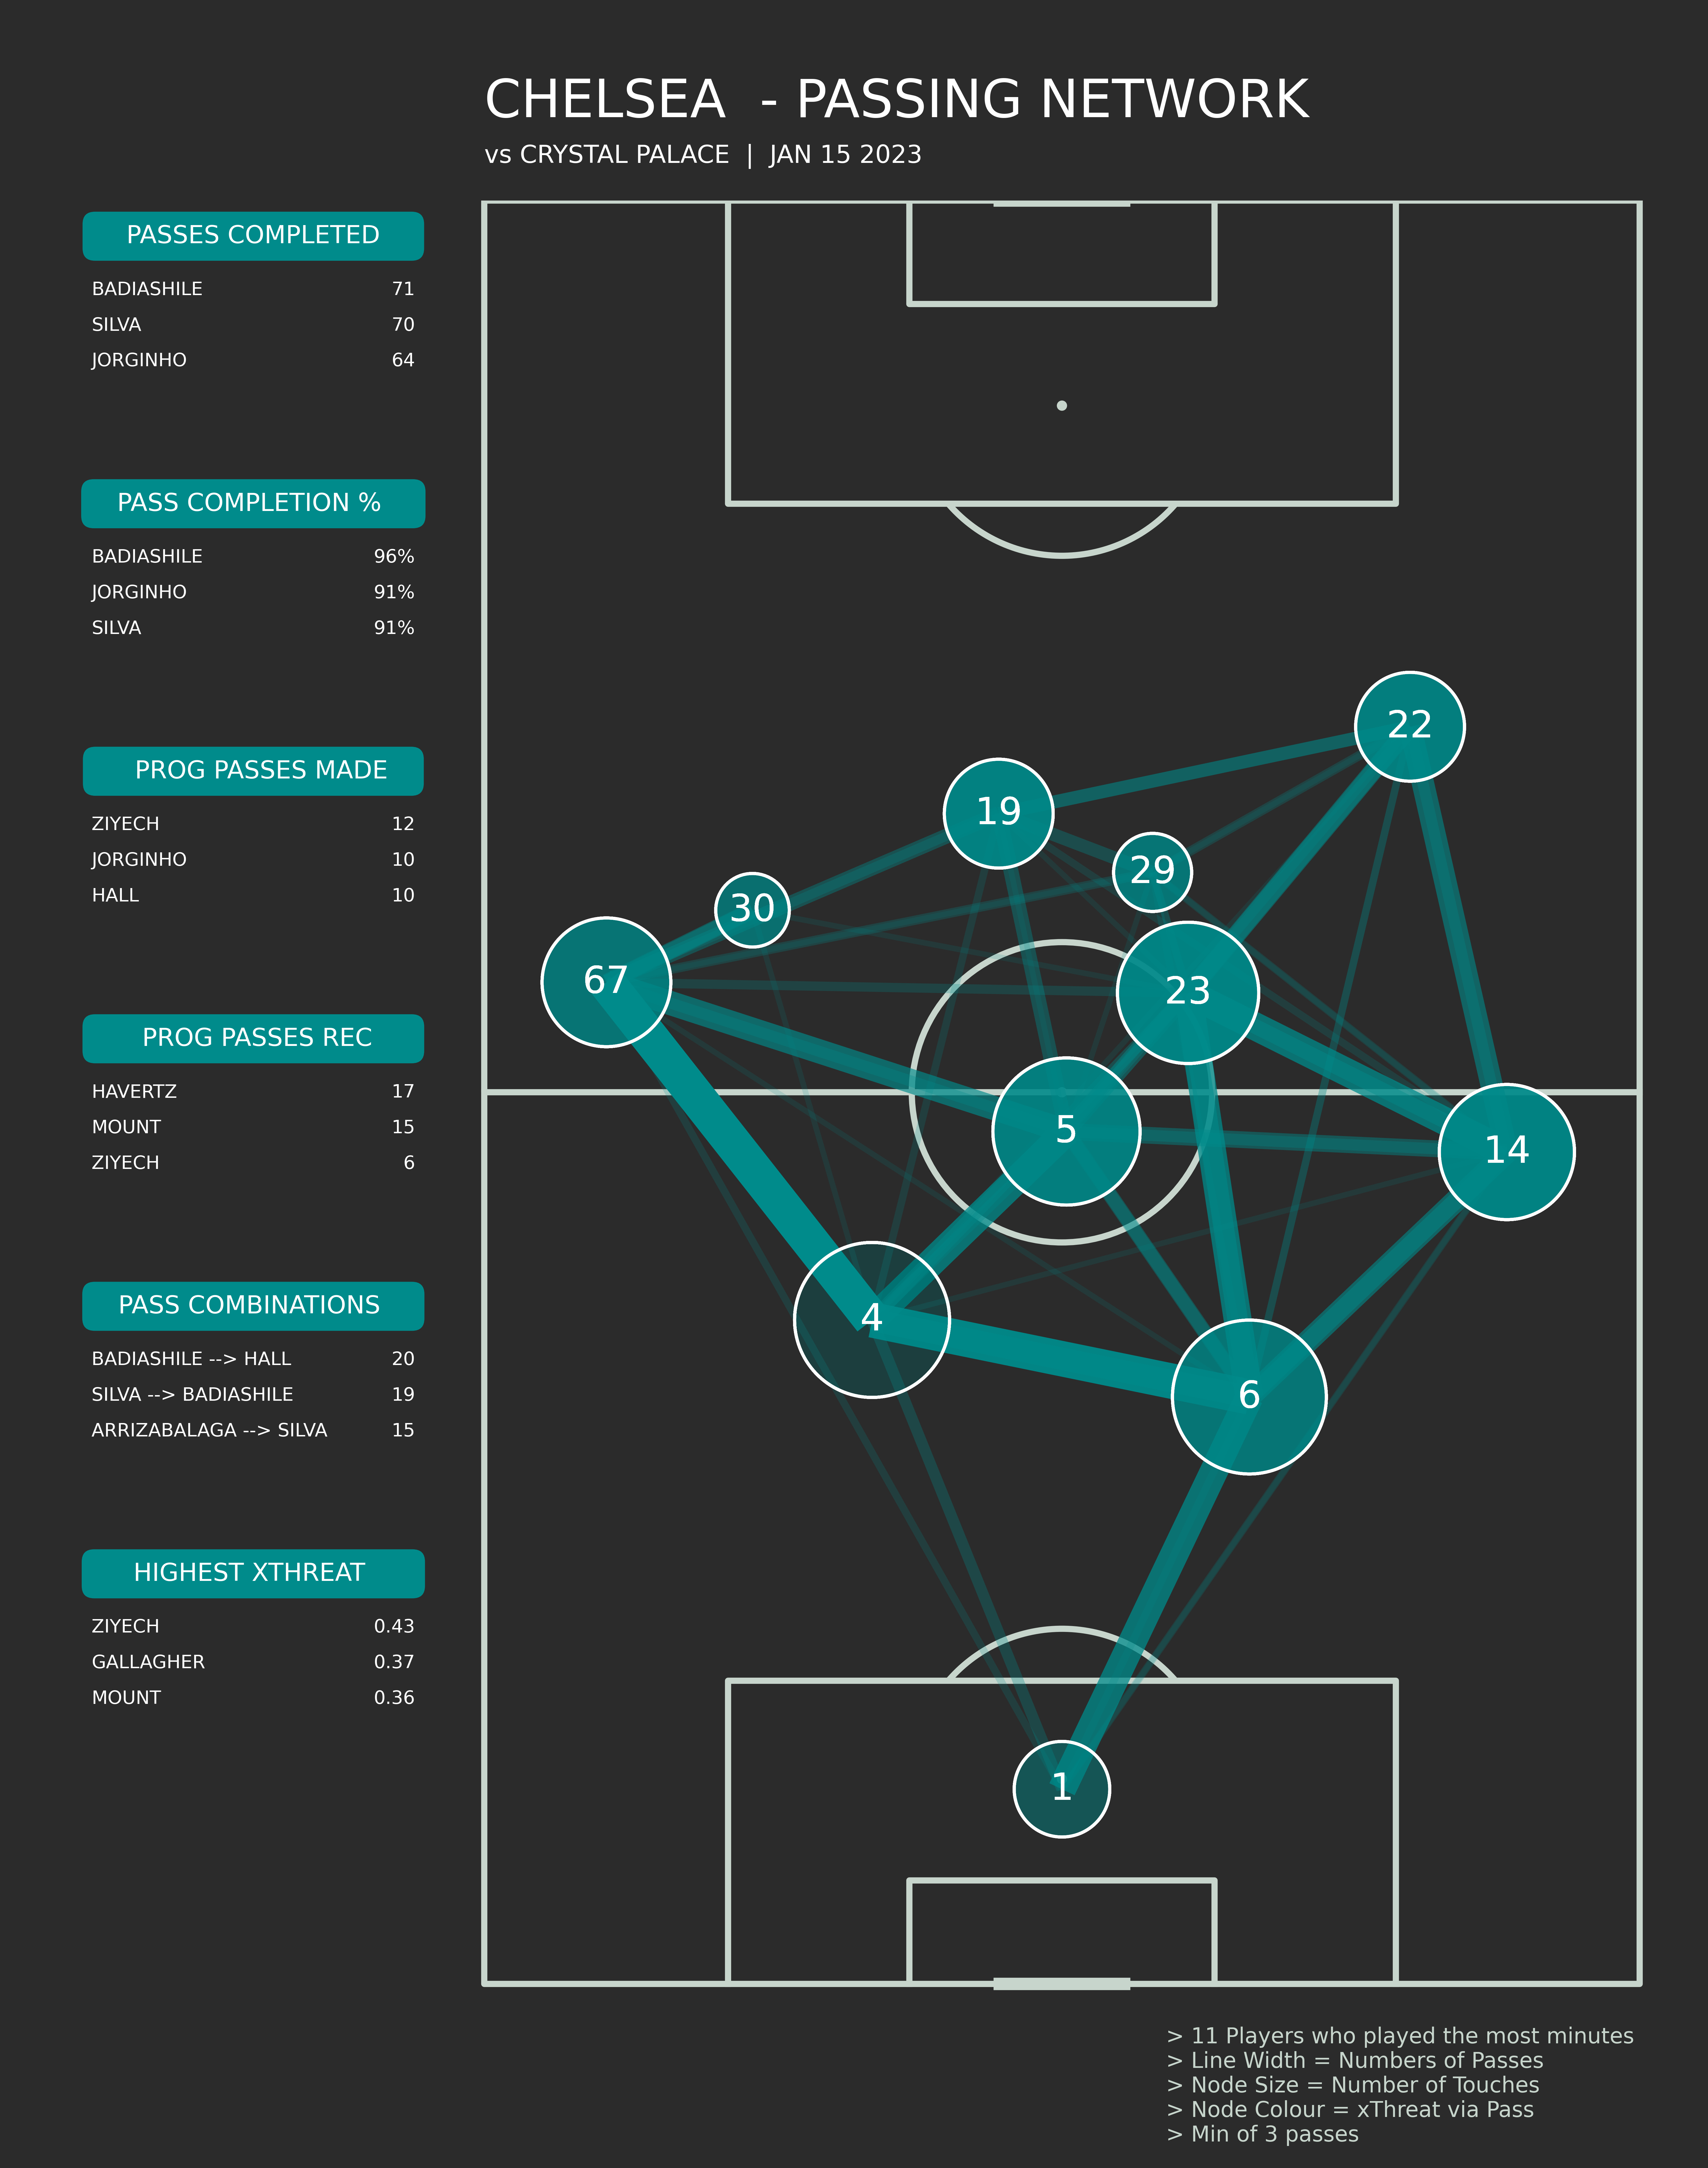

In [26]:
import matplotlib.pyplot as plt
from mplsoccer import Pitch, VerticalPitch
from matplotlib.colors import to_rgba
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 800

MIN_TRANSPARENCY = 0.
color = np.array(to_rgba('darkcyan'))
color = np.tile(color, (len(passes_t1), 1))
c_transparency = passes_t1.passes / (passes_t1.passes.max())
c_transparency = (c_transparency * (1 - MIN_TRANSPARENCY)) + MIN_TRANSPARENCY
color[:, 3] = c_transparency

MIN_TRANSPARENCY2 = 0.05
color2 = np.array(to_rgba('darkcyan'))
color2 = np.tile(color2, (len(passes_t1), 1))
c_transparency2 = (passes_t1.xThreat + passes_t1.xThreat.min())/ ((passes_t1.xThreat.max() + abs(passes_t1.xThreat.min())))
c_transparency2 = (c_transparency2 + MIN_TRANSPARENCY2)/4
color2[:, 3] = c_transparency2


pitch = VerticalPitch(pitch_type='opta', pitch_color='#2B2B2B', line_color='#c7d5cc',pad_top=0, pad_left = 40)
fig, axs = pitch.grid(figheight=10, title_height=0.08, endnote_space=0, axis=False, 
                      title_space=0, grid_height=0.82, endnote_height=0.05)

fig.set_facecolor("#2B2B2B")

# rectangle1 = plt.Rectangle((0, 0),110,100, color='darkcyan')
# plt.gca().add_patch(rectangle1, ax=axs['left'])

axs['pitch'].annotate(text='    Passes Completed    '.upper(), xytext=(120, 98), xy=(60, 40), ha='center', 
                     va='center', color='white',
                     bbox=dict(facecolor='darkcyan', edgecolor='none', boxstyle='round,pad=.5'),
                     fontname = 'Sans Serif', fontsize=8)

y = 95
i = 0
for p1, cnt in comp_passes_list:
    p1 = p1.replace('-', ' ')
    p1 = p1.split(' ')
    if len(p1) > 2:
        name = "".join([x[0].upper() for x in p1])
        p1 = name
    elif len(p1) == 1:
        p1 = p1[0]
    else:
        p1 = p1[1]
    axs['pitch'].annotate(text=p1.upper(), 
                          xytext=(134, y - 2*i), xy=(20, 40), ha='left', va='center', 
                          color='white', fontname = 'Sans Serif', fontsize = 6)
    axs['pitch'].annotate(text=cnt, 
                          xytext=(106, y - 2*i), xy=(20, 40), ha='right', va='center', 
                          color='white', fontname = 'Sans Serif', fontsize = 6)
    
    i += 1
axs['pitch'].annotate(text='   Pass Completion %    '.upper(), xytext=(120, 83), xy=(60, 40), ha='center', va='center', color='white',
                     bbox=dict(facecolor='darkcyan', edgecolor='none', boxstyle='round,pad=.5'),
                     fontname = 'Sans Serif', fontsize=8)
y = 80
i = 0
for p1, cnt in pass_comp:
    p1 = p1.replace('-', ' ')
    p1 = p1.split(' ')
    if len(p1) > 2:
        name = "".join([x[0].upper() for x in p1])
        p1 = name
    elif len(p1) == 1:
        p1 = p1[0]
    else:
        p1 = p1[1]
    axs['pitch'].annotate(text=p1.upper(), 
                          xytext=(134, y - 2*i), xy=(20, 40), ha='left', va='center', 
                          color='white', fontname = 'Sans Serif', fontsize = 6)
    axs['pitch'].annotate(text=str(cnt)+'%', 
                          xytext=(106, y - 2*i), xy=(20, 40), ha='right', va='center', 
                          color='white', fontname = 'Sans Serif', fontsize = 6)
    
    i += 1



axs['pitch'].annotate(text='     Prog Passes Made   '.upper(), xytext=(120, 68), xy=(60, 40), ha='center', va='center', color='white',
                     bbox=dict(facecolor='darkcyan', edgecolor='none', boxstyle='round,pad=.5'),
                     fontname = 'Sans Serif', fontsize=8)
y = 65
i = 0
for p1, cnt in prog_passes_list:
    p1 = p1.replace('-', ' ')
    p1 = p1.split(' ')
    if len(p1) > 2:
        name = "".join([x[0].upper() for x in p1])
        p1 = name
    elif len(p1) == 1:
        p1 = p1[0]
    else:
        p1 = p1[1]
    axs['pitch'].annotate(text=p1.upper(), 
                          xytext=(134, y - 2*i), xy=(20, 40), ha='left', va='center', 
                          color='white', fontname = 'Sans Serif', fontsize = 6)
    axs['pitch'].annotate(text=cnt, 
                          xytext=(106, y - 2*i), xy=(20, 40), ha='right', va='center', 
                          color='white', fontname = 'Sans Serif', fontsize = 6)
    
    i += 1

axs['pitch'].annotate(text='      Prog Passes Rec     '.upper(), xytext=(120, 53), xy=(60, 40), ha='center', va='center', color='white',
                     bbox=dict(facecolor='darkcyan', edgecolor='none', boxstyle='round,pad=.5'),
                     fontname = 'Sans Serif', fontsize=8)
y = 50
i = 0
for p1, cnt in prog_received_list:
    p1 = p1.replace('-', ' ')
    p1 = p1.split(' ')
    if len(p1) > 2:
        name = "".join([x[0].upper() for x in p1])
        p1 = name
    elif len(p1) == 1:
        p1 = p1[0]
    else:
        p1 = p1[1]
    axs['pitch'].annotate(text=p1.upper(), 
                          xytext=(134, y - 2*i), xy=(20, 40), ha='left', va='center', 
                          color='white', fontname = 'Sans Serif', fontsize = 6)
    axs['pitch'].annotate(text=cnt, 
                          xytext=(106, y - 2*i), xy=(20, 40), ha='right', va='center', 
                          color='white', fontname = 'Sans Serif', fontsize = 6)
    
    i += 1


axs['pitch'].annotate(text='   Pass Combinations    '.upper(), xytext=(120, 38), xy=(60, 40), ha='center', va='center', color='white',
                     bbox=dict(facecolor='darkcyan', edgecolor='none', boxstyle='round,pad=.5'),
                     fontname = 'Sans Serif', fontsize=8)
y = 35
i = 0
for p1, p2, cnt in combos_list:
    p1 = p1.replace('-', ' ')
    p1 = p1.split(' ')
    if len(p1) > 2:
        name = "".join([x[0].upper() for x in p1])
        p1 = name
    elif len(p1) == 1:
        p1 = p1[0]
    else:
        p1 = p1[1]
        
    p2 = p2.replace('-', ' ')
    p2 = p2.split(' ')
    if len(p2) > 2:
        name = "".join([x[0].upper() for x in p2])
        p2 = name
    elif len(p2) == 1:
        p2 = p2[0]
    else:
        p2 = p2[1]

    axs['pitch'].annotate(text=p1.upper() + ' --> ' + p2.upper(), 
                          xytext=(134, y - 2*i), xy=(20, 40), ha='left', va='center', 
                          color='white', fontname = 'Sans Serif', fontsize = 6)
    axs['pitch'].annotate(text=cnt, 
                          xytext=(106, y - 2*i), xy=(20, 40), ha='right', va='center', 
                          color='white', fontname = 'Sans Serif', fontsize = 6)
    
    i += 1

axs['pitch'].annotate(text='     Highest xThreat      '.upper(), xytext=(120, 23), xy=(60, 40), ha='center', va='center', color='white',
                     bbox=dict(facecolor='darkcyan', edgecolor='none', boxstyle='round,pad=.5'),
                     fontname = 'Sans Serif', fontsize=8)

y = 20
i = 0
for p1, cnt in xT_list:
    p1 = p1.replace('-', ' ')
    p1 = p1.split(' ')
    if len(p1) > 2:
        name = "".join([x[0].upper() for x in p1])
        p1 = name
    elif len(p1) == 1:
        p1 = p1[0]
    else:
        p1 = p1[1]
        
    axs['pitch'].annotate(text=p1.upper(), 
                          xytext=(134, y - 2*i), xy=(20, 40), ha='left', va='center', 
                          color='white', fontname = 'Sans Serif', fontsize = 6)
    axs['pitch'].annotate(text=str(cnt), 
                          xytext=(106, y - 2*i), xy=(20, 40), ha='right', va='center', 
                          color='white', fontname = 'Sans Serif', fontsize = 6)
    
    i += 1


# pass_arrows = pitch.arrows(passes_t1.x_start-1, passes_t1.y_start-1,
#                          passes_t1.x_end-1, passes_t1.y_end-1, lw=passes_t1.width,
#                          color=color, zorder=1, ax=axs['pitch'], headlength=6, 
#                          headwidth=4, headaxislength=3)

pass_lines = pitch.lines(passes_t1.x_start, passes_t1.y_start,
                         passes_t1.x_end, passes_t1.y_end, lw=passes_t1.width,
                         color=color, zorder=1, ax=axs['pitch'])


pass_nodes = pitch.scatter(passes_t1.x_start, passes_t1.y_start, s=passes_t1.marker_size,
                           color=color2, edgecolors='white', linewidth=1, ax=axs['pitch'])

for index, row in passes_t1.iterrows():
    pitch.annotate(row.no, xy=(row.x_start, row.y_start), color='white', va='center',
                   ha='center', size=12, ax=axs['pitch'], fontname='Sans Serif')
    
    
axs['title'].text(0, 0.55, home_name.upper() + '  - Passing Network'.upper(), color='White',
                  va='center', ha='left', fontsize=17, fontname='Sans Serif')
axs['title'].text(0, 0.25, 'vs ' + away_name.upper() + '  |  ' + date_str.upper(), color='White',
                  va='center', ha='left', fontsize=8)
    

axs['endnote'].set_xlim(0, 1)
axs['endnote'].set_ylim(0, 1)

axs['endnote'].text(0.59, 0.5, '> 11 Players who played the most minutes \n> Line Width = Numbers of Passes \n> Node Size = Number of Touches \n> Node Colour = xThreat via Pass \n> Min of 3 passes' , color='#c7d5cc',
                    va='center', ha='left', fontsize=7, fontname = 'Sans Serif')


fig.savefig('passNetwork.png', dpi=900)

plt.show()
